# Аналитика клиентов и групп товаров

## Цели анализа:
1. **RFM-анализ** с динамикой по годам (2023-2025)
2. **Статусы клиентов**: новые, постоянные, ушедшие, вернувшиеся
3. **Анализ групп товаров** с привязкой к типам клиентов
4. **Интерактивный дашборд** с фильтрами

## Методология:
- **Аналитика клиентов** — без числа чеков (факт покупки, сумма, количество товаров)
- **Аналитика групп** — с числом чеков (популярность, средний чек группы)

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Plotly для интерактивных графиков
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Для кластеризации
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print('Библиотеки загружены')

## 1. Загрузка и парсинг данных

In [37]:
# Загрузка Excel файла
file_path = 'test_sales_data.xlsx'
df_raw = pd.read_excel(file_path, header=None)
print(f'Размер данных: {df_raw.shape}')
df_raw.head(6)

Размер данных: (1004, 3025)


,0,1,2,3,4,5,6,7,8,9,...,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024
0,NaN,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Январь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Группа 1,NaN,NaN,Группа 2,NaN,NaN,Группа 3,NaN,NaN,...,NaN,Группа 26,NaN,NaN,Группа 27,NaN,NaN,Группа 28,NaN,NaN
3,ИД клиента,Количество в чеке,Сумма в чеке,Число чеков,Количество в чеке,Сумма в чеке,Число чеков,Количество в чеке,Сумма в чеке,Число чеков,...,Число чеков,Количество в чеке,Сумма в чеке,Число чеков,Количество в чеке,Сумма в чеке,Число чеков,Количество в чеке,Сумма в чеке,Число чеков
4,CLIENT_0001,29,28966.08,8,39,89098.64,7,NaN,NaN,NaN,...,NaN,29,35332.25,2,13,48912.21,7,4,19172.68,1
5,CLIENT_0002,NaN,NaN,NaN,20,55359.27,6,26,27549.13,9,...,6,32,37317.79,6,3,1313.24,1,7,9411.68,2


In [38]:
# Парсинг сложной шапки (4 уровня: Год, Месяц, Группа, Показатель)
header_rows = df_raw.iloc[0:4].copy()
data_rows = df_raw.iloc[4:].copy()

# Заполняем пропуски в шапке (объединённые ячейки)
header_rows = header_rows.ffill(axis=1)

# Первый столбец - ID клиента
header_rows.iloc[:, 0] = ['', '', '', 'ID_клиента']

# Создаём мультииндекс для колонок
columns = pd.MultiIndex.from_arrays([
    header_rows.iloc[0].values,  # Год
    header_rows.iloc[1].values,  # Месяц
    header_rows.iloc[2].values,  # Группа
    header_rows.iloc[3].values   # Показатель
])

data_rows.columns = columns
data_rows = data_rows.reset_index(drop=True)

print(f'Данные с мультииндексом: {data_rows.shape}')
data_rows.head(3)

Данные с мультииндексом: (1000, 3025)


2023                                             \
                          Январь                                              
                        Группа 1                                   Группа 2   
    ID_клиента Количество в чеке Сумма в чеке Число чеков Количество в чеке   
0  CLIENT_0001                29     28966.08           8                39   
1  CLIENT_0002               NaN          NaN         NaN                20   
2  CLIENT_0003               NaN          NaN         NaN               NaN   

                                                                       ...  \
                                                                       ...   
                                    Группа 3                           ...   
  Сумма в чеке Число чеков Количество в чеке Сумма в чеке Число чеков  ...   
0     89098.64           7               NaN          NaN         NaN  ...   
1     55359.27           6                26     27549.13           9  ...   
2          NaN         NaN               NaN          NaN         NaN  ...   

         2025                                                               \
      Декабрь                                                                
    Группа 25         Группа 26                                  Группа 27   
  Число чеков Количество в чеке Сумма в чеке Число чеков Количество в чеке   
0         NaN                29     35332.25           2                13   
1           6                32     37317.79           6                 3   
2         NaN                37     72095.79           5                17   

                                                                       
                                                                       
                                   Группа 28                           
  Сумма в чеке Число чеков Количество в чеке Сумма в чеке Число чеков  
0     48912.21           7                 4     19172.68           1  
1      1313.24           1                 7      9411.68           2  
2      12281.9           9                10     40730.58           7  

[3 rows x 3025 columns]

In [39]:
# Извлекаем ID клиентов
client_ids = data_rows[('', '', '', 'ID_клиента')].values

# Убираем столбец ID из данных для преобразования
data_values = data_rows.drop(columns=[('', '', '', 'ID_клиента')])

print(f'Клиентов: {len(client_ids)}')
print(f'Столбцов данных: {data_values.shape[1]}')

Клиентов: 1000
Столбцов данных: 3024


In [40]:
# Преобразование в long format
records = []

for idx, client_id in enumerate(client_ids):
    row = data_values.iloc[idx]
    for col in data_values.columns:
        year, month, group, metric = col
        value = row[col]
        if pd.notna(value) and value != 0:
            records.append({
                'ID_клиента': client_id,
                'Год': int(year),
                'Месяц': month,
                'Группа': group,
                'Показатель': metric,
                'Значение': value
            })

df_long = pd.DataFrame(records)
print(f'Записей в long format: {len(df_long)}')
df_long.head(10)

Записей в long format: 2114733


,ID_клиента,Год,Месяц,Группа,Показатель,Значение
0,CLIENT_0001,2023,Январь,Группа 1,Количество в чеке,29.00
1,CLIENT_0001,2023,Январь,Группа 1,Сумма в чеке,28966.08
2,CLIENT_0001,2023,Январь,Группа 1,Число чеков,8.00
3,CLIENT_0001,2023,Январь,Группа 2,Количество в чеке,39.00
4,CLIENT_0001,2023,Январь,Группа 2,Сумма в чеке,89098.64
5,CLIENT_0001,2023,Январь,Группа 2,Число чеков,7.00
6,CLIENT_0001,2023,Январь,Группа 4,Количество в чеке,36.00
7,CLIENT_0001,2023,Январь,Группа 4,Сумма в чеке,28801.71
8,CLIENT_0001,2023,Январь,Группа 4,Число чеков,3.00
9,CLIENT_0001,2023,Январь,Группа 6,Количество в чеке,44.00


In [41]:
# Разворачиваем показатели в отдельные столбцы
df_pivot = df_long.pivot_table(
    index=['ID_клиента', 'Год', 'Месяц', 'Группа'],
    columns='Показатель',
    values='Значение',
    aggfunc='first'
).reset_index()

# Переименовываем столбцы
df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns={
    'Количество в чеке': 'Количество',
    'Сумма в чеке': 'Сумма',
    'Число чеков': 'Чеки'
})

# Преобразуем типы
df_pivot['Количество'] = pd.to_numeric(df_pivot['Количество'], errors='coerce')
df_pivot['Сумма'] = pd.to_numeric(df_pivot['Сумма'], errors='coerce')
df_pivot['Чеки'] = pd.to_numeric(df_pivot['Чеки'], errors='coerce')

print(f'Итоговый датасет: {df_pivot.shape}')
df_pivot.head(10)

Итоговый датасет: (704911, 7)


,ID_клиента,Год,Месяц,Группа,Количество,Сумма,Чеки
0,CLIENT_0001,2023,Август,Группа 1,1.0,2453.81,1.0
1,CLIENT_0001,2023,Август,Группа 10,13.0,14500.40,1.0
2,CLIENT_0001,2023,Август,Группа 11,32.0,10553.37,8.0
3,CLIENT_0001,2023,Август,Группа 13,3.0,7946.40,1.0
4,CLIENT_0001,2023,Август,Группа 14,5.0,2666.00,3.0
5,CLIENT_0001,2023,Август,Группа 15,48.0,117706.81,7.0
6,CLIENT_0001,2023,Август,Группа 16,21.0,67890.28,3.0
7,CLIENT_0001,2023,Август,Группа 17,34.0,61807.89,2.0
8,CLIENT_0001,2023,Август,Группа 18,15.0,33654.41,2.0
9,CLIENT_0001,2023,Август,Группа 19,38.0,87759.53,7.0


In [42]:
# Создаём числовой номер месяца
months_map = {
    'Январь': 1, 'Февраль': 2, 'Март': 3, 'Апрель': 4,
    'Май': 5, 'Июнь': 6, 'Июль': 7, 'Август': 8,
    'Сентябрь': 9, 'Октябрь': 10, 'Ноябрь': 11, 'Декабрь': 12
}
df_pivot['Месяц_номер'] = df_pivot['Месяц'].map(months_map)

# Создаём единый временной индекс (для удобства расчётов)
df_pivot['Период'] = df_pivot['Год'] * 100 + df_pivot['Месяц_номер']  # 202301, 202302, ...
df_pivot['Дата'] = pd.to_datetime(df_pivot['Год'].astype(str) + '-' + df_pivot['Месяц_номер'].astype(str) + '-01')

# Сортировка
df_pivot = df_pivot.sort_values(['ID_клиента', 'Период', 'Группа']).reset_index(drop=True)

print(f'Периоды: {df_pivot["Период"].min()} - {df_pivot["Период"].max()}')
print(f'Уникальных клиентов: {df_pivot["ID_клиента"].nunique()}')
print(f'Групп товаров: {df_pivot["Группа"].nunique()}')
df_pivot.head()

Периоды: 202301 - 202512
Уникальных клиентов: 1000
Групп товаров: 28


,ID_клиента,Год,Месяц,Группа,Количество,Сумма,Чеки,Месяц_номер,Период,Дата
0,CLIENT_0001,2023,Январь,Группа 1,29.0,28966.08,8.0,1,202301,2023-01-01
1,CLIENT_0001,2023,Январь,Группа 11,42.0,13803.79,3.0,1,202301,2023-01-01
2,CLIENT_0001,2023,Январь,Группа 12,3.0,12941.12,3.0,1,202301,2023-01-01
3,CLIENT_0001,2023,Январь,Группа 15,14.0,56856.06,9.0,1,202301,2023-01-01
4,CLIENT_0001,2023,Январь,Группа 19,44.0,111160.14,3.0,1,202301,2023-01-01


In [43]:
# Сохраняем основной датасет
df = df_pivot.copy()
print('Данные готовы к анализу!')
print(f'\nСтатистика:')
df[['Количество', 'Сумма', 'Чеки']].describe()

Данные готовы к анализу!

Статистика:


,Количество,Сумма,Чеки
count,704911.000000,704911.000000,704911.000000
mean,24.975593,63647.504510,4.631158
std,14.143807,54284.231409,2.608482
min,1.000000,100.130000,1.000000
25%,13.000000,18823.075000,2.000000
50%,25.000000,48361.870000,4.000000
75%,37.000000,96491.050000,7.000000
max,49.000000,244993.670000,9.000000


---
## 2. Аналитика клиентов (без числа чеков)

### Статусы клиентов по месяцам:
- **Новый** — покупка в текущем месяце, не было 12 месяцев до этого
- **Постоянный** — покупка сейчас и была за последние 6 месяцев
- **Ушедший** — была покупка 6+ мес назад, нет последние 6 месяцев
- **Вернувшийся** — покупка сейчас, не было 6 месяцев, но был ранее

In [44]:
# Агрегируем данные по клиенту и месяцу (без учёта групп и чеков)
df_client_month = df.groupby(['ID_клиента', 'Год', 'Месяц', 'Месяц_номер', 'Период', 'Дата']).agg({
    'Сумма': 'sum',
    'Количество': 'sum'
}).reset_index()

# Добавляем флаг активности
df_client_month['Активен'] = 1

print(f'Записей клиент-месяц: {len(df_client_month)}')
df_client_month.head(10)

Записей клиент-месяц: 36000


,ID_клиента,Год,Месяц,Месяц_номер,Период,Дата,Сумма,Количество,Активен
0,CLIENT_0001,2023,Август,8,202308,2023-08-01,1237980.05,531.0,1
1,CLIENT_0001,2023,Апрель,4,202304,2023-04-01,1557962.97,482.0,1
2,CLIENT_0001,2023,Декабрь,12,202312,2023-12-01,1317177.03,462.0,1
3,CLIENT_0001,2023,Июль,7,202307,2023-07-01,1287135.97,483.0,1
4,CLIENT_0001,2023,Июнь,6,202306,2023-06-01,1634878.17,530.0,1
5,CLIENT_0001,2023,Май,5,202305,2023-05-01,1270808.18,473.0,1
6,CLIENT_0001,2023,Март,3,202303,2023-03-01,1116205.76,563.0,1
7,CLIENT_0001,2023,Ноябрь,11,202311,2023-11-01,1615956.14,606.0,1
8,CLIENT_0001,2023,Октябрь,10,202310,2023-10-01,999481.00,422.0,1
9,CLIENT_0001,2023,Сентябрь,9,202309,2023-09-01,791791.09,403.0,1


In [45]:
# Создаём полную матрицу клиент × период
all_clients = df_client_month['ID_клиента'].unique()
all_periods = sorted(df_client_month['Период'].unique())

# Создаём справочник периодов
period_info = df_client_month[['Период', 'Год', 'Месяц', 'Месяц_номер', 'Дата']].drop_duplicates().sort_values('Период')
period_list = period_info['Период'].tolist()

print(f'Всего периодов: {len(period_list)}')
print(f'Периоды: {period_list[:6]} ... {period_list[-6:]}')

Всего периодов: 36
Периоды: [202301, 202302, 202303, 202304, 202305, 202306] ... [202507, 202508, 202509, 202510, 202511, 202512]


In [46]:
# Создаём матрицу активности клиентов
activity_matrix = df_client_month.pivot_table(
    index='ID_клиента',
    columns='Период',
    values='Активен',
    fill_value=0
)

print(f'Матрица активности: {activity_matrix.shape}')
activity_matrix.head()

Матрица активности: (1000, 36)


Период,202301,202302,202303,202304,202305,202306,202307,202308,202309,202310,...,202503,202504,202505,202506,202507,202508,202509,202510,202511,202512
ID_клиента,,,,,,,,,,,,,,,,,,,,,
CLIENT_0001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CLIENT_0002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CLIENT_0003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CLIENT_0004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CLIENT_0005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [47]:
def get_client_status(activity_matrix, period_list, current_period_idx):
    """
    Определяет статус каждого клиента для заданного периода.
    
    Статусы:
    - Новый: активен сейчас, не было 12 мес до этого
    - Постоянный: активен сейчас и был за последние 6 мес
    - Вернувшийся: активен сейчас, не было 6 мес, но был ранее
    - Ушедший: был 6+ мес назад, нет последние 6 мес
    - Неактивный: не было покупок вообще или очень давно
    """
    current_period = period_list[current_period_idx]
    
    # Периоды для анализа
    last_6_periods = period_list[max(0, current_period_idx-6):current_period_idx]
    last_12_periods = period_list[max(0, current_period_idx-12):current_period_idx]
    before_6_periods = period_list[:max(0, current_period_idx-6)]
    
    statuses = {}
    
    for client in activity_matrix.index:
        # Текущая активность
        is_active_now = activity_matrix.loc[client, current_period] == 1 if current_period in activity_matrix.columns else False
        
        # Активность за последние 6 месяцев (до текущего)
        active_last_6 = any(activity_matrix.loc[client, p] == 1 for p in last_6_periods if p in activity_matrix.columns)
        
        # Активность за последние 12 месяцев (до текущего)
        active_last_12 = any(activity_matrix.loc[client, p] == 1 for p in last_12_periods if p in activity_matrix.columns)
        
        # Активность ранее 6 месяцев назад
        active_before_6 = any(activity_matrix.loc[client, p] == 1 for p in before_6_periods if p in activity_matrix.columns)
        
        if is_active_now:
            if not active_last_12:
                statuses[client] = 'Новый'
            elif active_last_6:
                statuses[client] = 'Постоянный'
            else:  # не было 6 мес, но был ранее
                statuses[client] = 'Вернувшийся'
        else:
            if active_before_6 and not active_last_6:
                statuses[client] = 'Ушедший'
            elif active_last_6:
                statuses[client] = 'Спящий'  # был недавно, но не в этом месяце
            else:
                statuses[client] = 'Неактивный'
    
    return statuses

In [48]:
# Рассчитываем статусы для всех периодов начиная с 2024 (чтобы было 12 мес истории)
# Находим индекс января 2024
start_period = 202401
start_idx = period_list.index(start_period) if start_period in period_list else 12

print(f'Начинаем расчёт статусов с периода {period_list[start_idx]} (индекс {start_idx})')

all_statuses = []

for idx in range(start_idx, len(period_list)):
    period = period_list[idx]
    statuses = get_client_status(activity_matrix, period_list, idx)
    
    for client, status in statuses.items():
        all_statuses.append({
            'ID_клиента': client,
            'Период': period,
            'Статус': status
        })

df_statuses = pd.DataFrame(all_statuses)

# Добавляем информацию о периоде
df_statuses = df_statuses.merge(period_info, on='Период')

print(f'\nРаспределение статусов по всем периодам:')
print(df_statuses['Статус'].value_counts())

Начинаем расчёт статусов с периода 202401 (индекс 12)

Распределение статусов по всем периодам:
Статус
Постоянный    24000
Name: count, dtype: int64


In [49]:
# Динамика статусов по месяцам
status_dynamics = df_statuses.groupby(['Период', 'Год', 'Месяц', 'Статус']).size().reset_index(name='Количество')
status_dynamics = status_dynamics.sort_values('Период')

# Создаём метку для оси X
status_dynamics['Период_название'] = status_dynamics['Месяц'] + ' ' + status_dynamics['Год'].astype(str)

status_dynamics.head(20)

,Период,Год,Месяц,Статус,Количество,Период_название
0,202401,2024,Январь,Постоянный,1000,Январь 2024
1,202402,2024,Февраль,Постоянный,1000,Февраль 2024
2,202403,2024,Март,Постоянный,1000,Март 2024
3,202404,2024,Апрель,Постоянный,1000,Апрель 2024
4,202405,2024,Май,Постоянный,1000,Май 2024
5,202406,2024,Июнь,Постоянный,1000,Июнь 2024
6,202407,2024,Июль,Постоянный,1000,Июль 2024
7,202408,2024,Август,Постоянный,1000,Август 2024
8,202409,2024,Сентябрь,Постоянный,1000,Сентябрь 2024
9,202410,2024,Октябрь,Постоянный,1000,Октябрь 2024


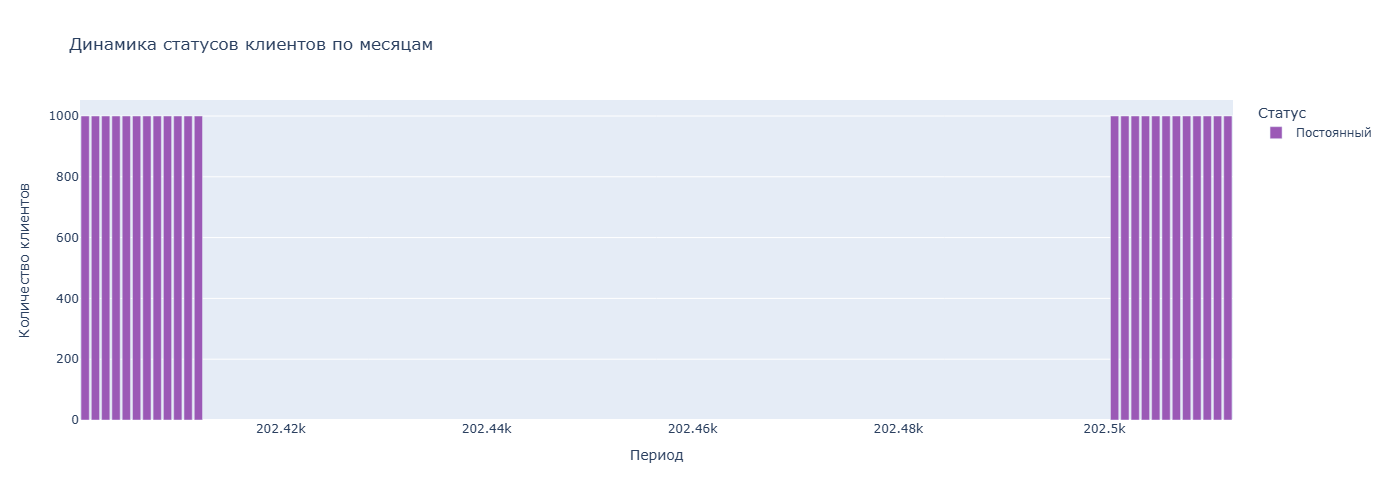

In [50]:
# График: Динамика статусов клиентов
status_order = ['Новый', 'Вернувшийся', 'Постоянный', 'Спящий', 'Ушедший', 'Неактивный']
colors = {
    'Новый': '#2ecc71',
    'Вернувшийся': '#3498db', 
    'Постоянный': '#9b59b6',
    'Спящий': '#f39c12',
    'Ушедший': '#e74c3c',
    'Неактивный': '#95a5a6'
}

fig = px.bar(
    status_dynamics,
    x='Период',
    y='Количество',
    color='Статус',
    title='Динамика статусов клиентов по месяцам',
    category_orders={'Статус': status_order},
    color_discrete_map=colors,
    barmode='stack'
)

fig.update_layout(
    xaxis_title='Период',
    yaxis_title='Количество клиентов',
    legend_title='Статус',
    height=500
)

fig.show()

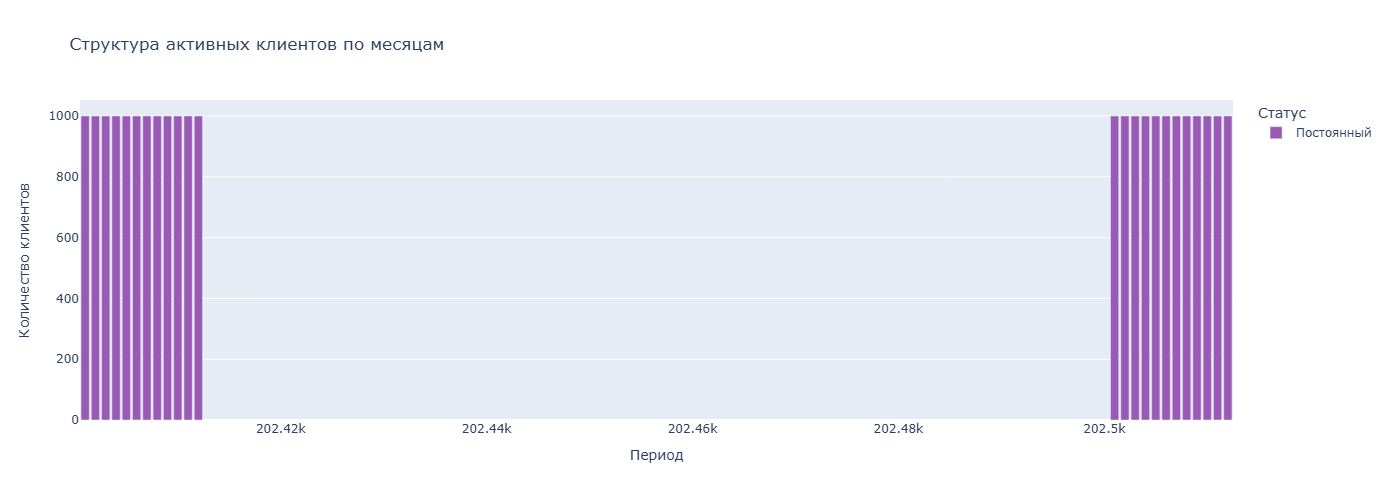

In [51]:
# Только активные статусы (без Неактивных)
active_statuses = ['Новый', 'Вернувшийся', 'Постоянный']
status_active = status_dynamics[status_dynamics['Статус'].isin(active_statuses)]

fig = px.bar(
    status_active,
    x='Период',
    y='Количество',
    color='Статус',
    title='Структура активных клиентов по месяцам',
    category_orders={'Статус': active_statuses},
    color_discrete_map=colors,
    barmode='stack'
)

fig.update_layout(
    xaxis_title='Период',
    yaxis_title='Количество клиентов',
    legend_title='Статус',
    height=500
)

fig.show()

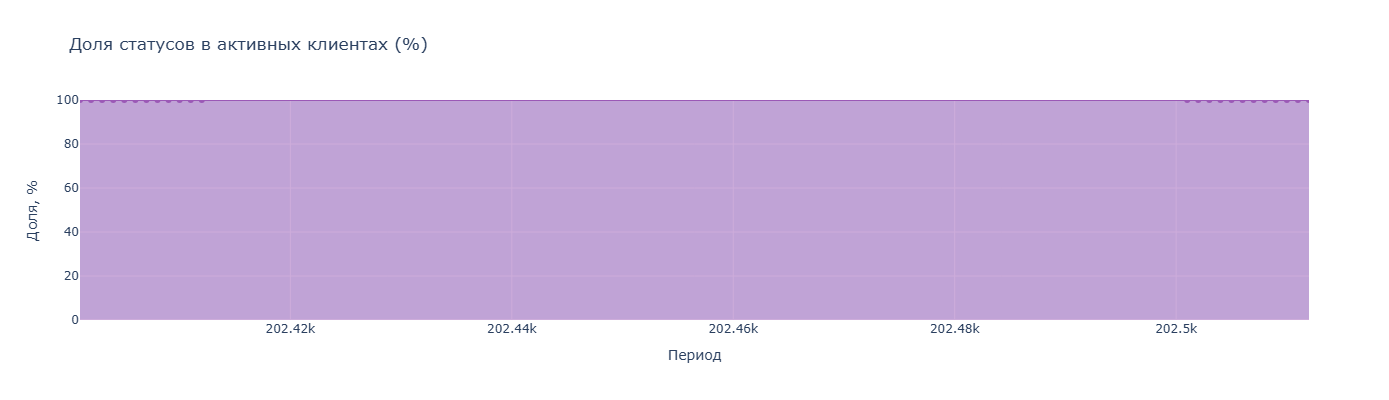

In [52]:
# Доля активных статусов
status_pivot = status_active.pivot_table(
    index='Период',
    columns='Статус',
    values='Количество',
    fill_value=0
).reset_index()

# Берём только статусы, которые реально есть в данных
available_statuses = [s for s in active_statuses if s in status_pivot.columns]

if available_statuses:
    status_pivot['Всего'] = status_pivot[available_statuses].sum(axis=1)
    for s in available_statuses:
        status_pivot[f'{s}_доля'] = status_pivot[s] / status_pivot['Всего'] * 100

    fig = go.Figure()

    for status in available_statuses:
        fig.add_trace(go.Scatter(
            x=status_pivot['Период'],
            y=status_pivot[f'{status}_доля'],
            name=status,
            mode='lines+markers',
            line=dict(color=colors[status]),
            stackgroup='one'
        ))

    fig.update_layout(
        title='Доля статусов в активных клиентах (%)',
        xaxis_title='Период',
        yaxis_title='Доля, %',
        height=400,
        yaxis=dict(range=[0, 100])
    )

    fig.show()
else:
    print('Нет активных статусов для отображения')

---
## 3. RFM-анализ по годам

In [53]:
# Расчёт RFM по годам
def calculate_rfm_year(df_client_month, year):
    """
    R = последний месяц покупки (12 = декабрь = свежий)
    F = количество месяцев с покупками
    M = общая сумма за год
    """
    df_year = df_client_month[df_client_month['Год'] == year].copy()
    
    rfm = df_year.groupby('ID_клиента').agg({
        'Месяц_номер': 'max',  # R: последний месяц
        'Период': 'count',      # F: кол-во месяцев с покупками
        'Сумма': 'sum'          # M: общая сумма
    }).reset_index()
    
    rfm.columns = ['ID_клиента', 'R', 'F', 'M']
    rfm['Год'] = year
    
    return rfm

# RFM для каждого года
rfm_2023 = calculate_rfm_year(df_client_month, 2023)
rfm_2024 = calculate_rfm_year(df_client_month, 2024)
rfm_2025 = calculate_rfm_year(df_client_month, 2025)

df_rfm = pd.concat([rfm_2023, rfm_2024, rfm_2025], ignore_index=True)

print(f'RFM записей: {len(df_rfm)}')
df_rfm.head(10)

RFM записей: 3000


,ID_клиента,R,F,M,Год
0,CLIENT_0001,12,12,14668372.01,2023
1,CLIENT_0002,12,12,14250000.54,2023
2,CLIENT_0003,12,12,14446477.72,2023
3,CLIENT_0004,12,12,14800924.80,2023
4,CLIENT_0005,12,12,15785175.50,2023
5,CLIENT_0006,12,12,15302650.30,2023
6,CLIENT_0007,12,12,14494514.26,2023
7,CLIENT_0008,12,12,15066285.41,2023
8,CLIENT_0009,12,12,16145464.43,2023
9,CLIENT_0010,12,12,16727199.59,2023


In [54]:
# Кластеризация RFM (5 кластеров)
def rfm_clustering(rfm_df):
    """
    K-means кластеризация с присвоением названий кластерам.
    """
    # Нормализация
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_df[['R', 'F', 'M']])
    
    # K-means
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    rfm_df['Кластер_номер'] = kmeans.fit_predict(rfm_scaled)
    
    # Средние значения по кластерам для определения названий
    cluster_means = rfm_df.groupby('Кластер_номер')[['R', 'F', 'M']].mean()
    
    # Нормализуем средние для ранжирования
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    cluster_means['Score'] = cluster_means_norm.sum(axis=1)
    
    # Сортируем по общему скору
    cluster_rank = cluster_means['Score'].sort_values(ascending=False)
    
    # Присваиваем названия
    names = ['Чемпионы', 'Лояльные', 'Перспективные', 'Требуют внимания', 'Потерянные']
    name_map = {cluster_rank.index[i]: names[i] for i in range(5)}
    
    rfm_df['Кластер'] = rfm_df['Кластер_номер'].map(name_map)
    
    return rfm_df, cluster_means

# Кластеризация для каждого года отдельно
rfm_results = []
for year in [2023, 2024, 2025]:
    rfm_year = df_rfm[df_rfm['Год'] == year].copy()
    if len(rfm_year) > 5:
        rfm_year, _ = rfm_clustering(rfm_year)
        rfm_results.append(rfm_year)

df_rfm_clustered = pd.concat(rfm_results, ignore_index=True)

print('Распределение по кластерам:')
print(df_rfm_clustered.groupby(['Год', 'Кластер']).size().unstack(fill_value=0))

Распределение по кластерам:
Кластер  Лояльные  Перспективные  Потерянные  Требуют внимания  Чемпионы
Год                                                                     
2023          279            297          86               206       132
2024          244            274         122               258       102
2025          206            305         140               246       103


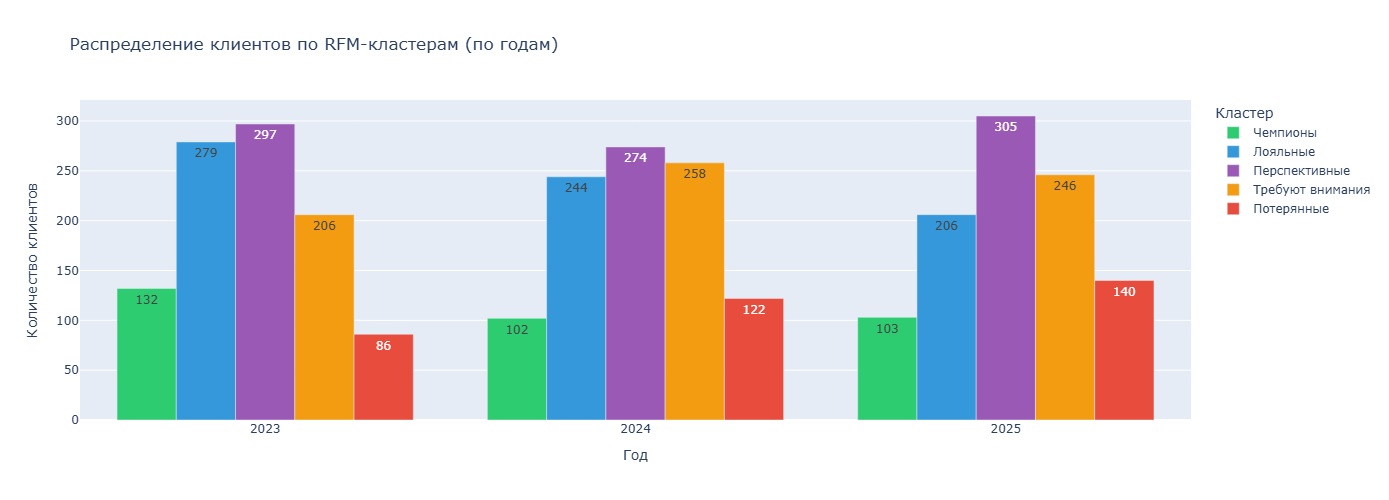

In [55]:
# График: Распределение кластеров по годам
cluster_counts = df_rfm_clustered.groupby(['Год', 'Кластер']).size().reset_index(name='Количество')

cluster_order = ['Чемпионы', 'Лояльные', 'Перспективные', 'Требуют внимания', 'Потерянные']
cluster_colors = {
    'Чемпионы': '#2ecc71',
    'Лояльные': '#3498db',
    'Перспективные': '#9b59b6',
    'Требуют внимания': '#f39c12',
    'Потерянные': '#e74c3c'
}

fig = px.bar(
    cluster_counts,
    x='Год',
    y='Количество',
    color='Кластер',
    title='Распределение клиентов по RFM-кластерам (по годам)',
    category_orders={'Кластер': cluster_order},
    color_discrete_map=cluster_colors,
    barmode='group',
    text='Количество'
)

fig.update_layout(
    xaxis_title='Год',
    yaxis_title='Количество клиентов',
    height=500
)

fig.show()

In [56]:
# Характеристики кластеров
cluster_stats = df_rfm_clustered.groupby('Кластер').agg({
    'R': 'mean',
    'F': 'mean',
    'M': 'mean',
    'ID_клиента': 'count'
}).round(2)

cluster_stats.columns = ['Ср. последний месяц (R)', 'Ср. месяцев покупок (F)', 'Ср. сумма (M)', 'Всего клиентов']
cluster_stats = cluster_stats.reindex(cluster_order)

print('Характеристики кластеров:')
cluster_stats

Характеристики кластеров:


,Ср. последний месяц (R),Ср. месяцев покупок (F),Ср. сумма (M),Всего клиентов
Кластер,,,,
Чемпионы,12.0,12.0,16634246.25,337
Лояльные,12.0,12.0,15680649.39,729
Перспективные,12.0,12.0,14960045.77,876
Требуют внимания,12.0,12.0,14214814.81,710
Потерянные,12.0,12.0,13308543.25,348


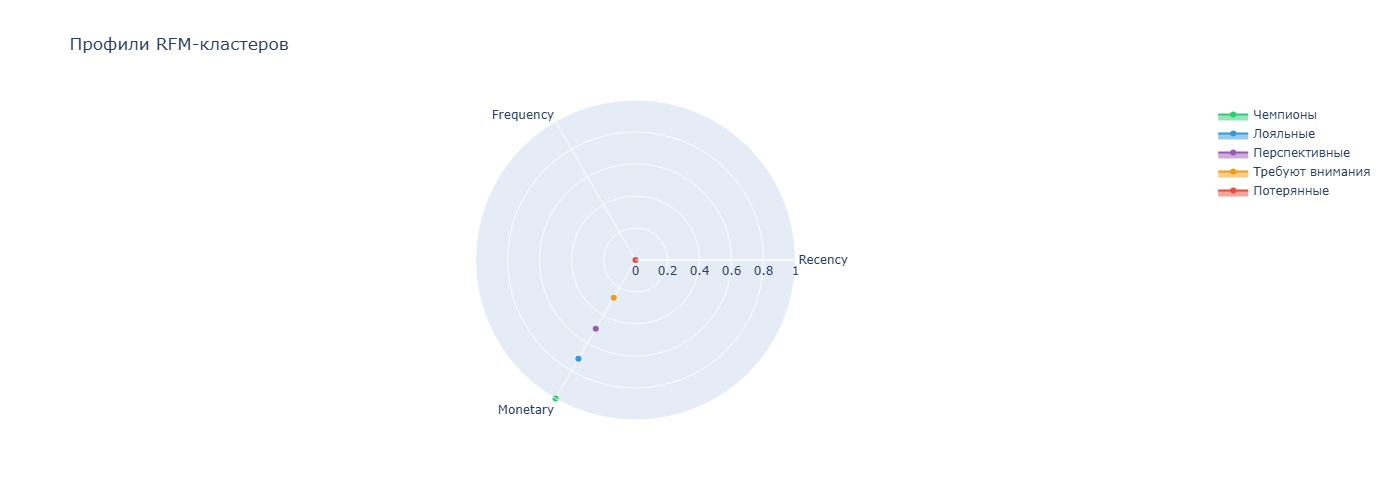

In [57]:
# Radar chart для профилей кластеров
cluster_profile = df_rfm_clustered.groupby('Кластер')[['R', 'F', 'M']].mean()

# Нормализуем для radar
cluster_profile_norm = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

fig = go.Figure()

for cluster in cluster_order:
    if cluster in cluster_profile_norm.index:
        values = cluster_profile_norm.loc[cluster].tolist()
        values.append(values[0])  # замыкаем
        
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=['Recency', 'Frequency', 'Monetary', 'Recency'],
            fill='toself',
            name=cluster,
            line_color=cluster_colors[cluster]
        ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    title='Профили RFM-кластеров',
    height=500
)

fig.show()

---
## 4. Миграция клиентов между кластерами

In [58]:
# Создаём таблицу миграции
migration = df_rfm_clustered.pivot_table(
    index='ID_клиента',
    columns='Год',
    values='Кластер',
    aggfunc='first'
).reset_index()

# Заполняем пропуски для клиентов без покупок в году
migration = migration.fillna('Нет покупок')

print(f'Клиентов в миграции: {len(migration)}')
migration.head(10)

Клиентов в миграции: 1000


Год,ID_клиента,2023,2024,2025
0,CLIENT_0001,Перспективные,Перспективные,Требуют внимания
1,CLIENT_0002,Требуют внимания,Требуют внимания,Требуют внимания
2,CLIENT_0003,Требуют внимания,Лояльные,Требуют внимания
3,CLIENT_0004,Перспективные,Требуют внимания,Перспективные
4,CLIENT_0005,Лояльные,Потерянные,Требуют внимания
5,CLIENT_0006,Лояльные,Чемпионы,Лояльные
6,CLIENT_0007,Перспективные,Лояльные,Требуют внимания
7,CLIENT_0008,Перспективные,Чемпионы,Лояльные
8,CLIENT_0009,Чемпионы,Лояльные,Чемпионы
9,CLIENT_0010,Чемпионы,Требуют внимания,Требуют внимания


In [59]:
# Матрица переходов 2023 → 2024
transition_23_24 = pd.crosstab(migration[2023], migration[2024], margins=True)
print('Переходы 2023 → 2024:')
transition_23_24

Переходы 2023 → 2024:


2024,Лояльные,Перспективные,Потерянные,Требуют внимания,Чемпионы,All
2023,,,,,,
Лояльные,71,79,32,68,29,279
Перспективные,82,79,31,74,31,297
Потерянные,21,21,7,31,6,86
Требуют внимания,46,55,35,48,22,206
Чемпионы,24,40,17,37,14,132
All,244,274,122,258,102,1000


In [60]:
# Матрица переходов 2024 → 2025
transition_24_25 = pd.crosstab(migration[2024], migration[2025], margins=True)
print('Переходы 2024 → 2025:')
transition_24_25

Переходы 2024 → 2025:


2025,Лояльные,Перспективные,Потерянные,Требуют внимания,Чемпионы,All
2024,,,,,,
Лояльные,45,72,32,70,25,244
Перспективные,58,81,36,63,36,274
Потерянные,23,40,13,34,12,122
Требуют внимания,59,81,40,55,23,258
Чемпионы,21,31,19,24,7,102
All,206,305,140,246,103,1000


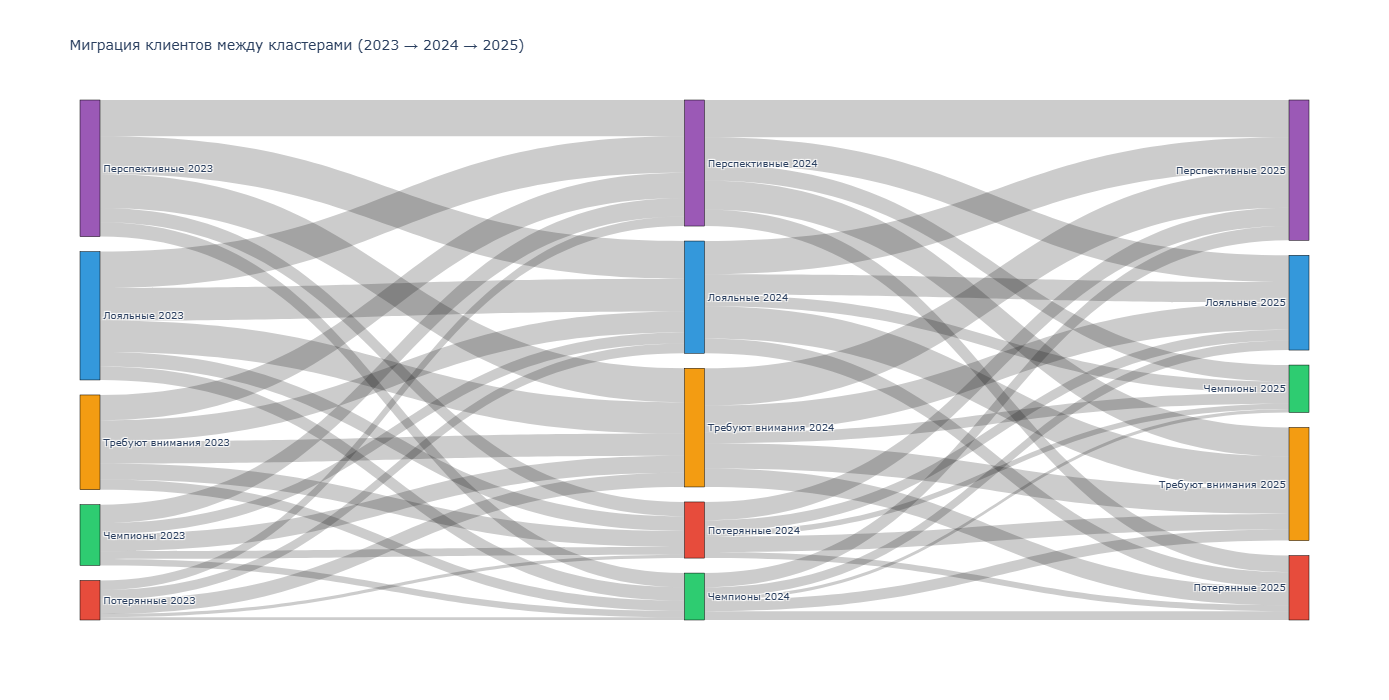

In [61]:
# Sankey диаграмма миграции 2023 → 2024 → 2025
all_labels = (
    [f'{c} 2023' for c in cluster_order + ['Нет покупок']] +
    [f'{c} 2024' for c in cluster_order + ['Нет покупок']] +
    [f'{c} 2025' for c in cluster_order + ['Нет покупок']]
)

label_to_idx = {label: idx for idx, label in enumerate(all_labels)}

sources = []
targets = []
values = []

# 2023 → 2024
for from_cluster in cluster_order + ['Нет покупок']:
    for to_cluster in cluster_order + ['Нет покупок']:
        count = len(migration[(migration[2023] == from_cluster) & (migration[2024] == to_cluster)])
        if count > 0:
            sources.append(label_to_idx[f'{from_cluster} 2023'])
            targets.append(label_to_idx[f'{to_cluster} 2024'])
            values.append(count)

# 2024 → 2025
for from_cluster in cluster_order + ['Нет покупок']:
    for to_cluster in cluster_order + ['Нет покупок']:
        count = len(migration[(migration[2024] == from_cluster) & (migration[2025] == to_cluster)])
        if count > 0:
            sources.append(label_to_idx[f'{from_cluster} 2024'])
            targets.append(label_to_idx[f'{to_cluster} 2025'])
            values.append(count)

# Цвета для Sankey
node_colors = []
for label in all_labels:
    for cluster, color in cluster_colors.items():
        if cluster in label:
            node_colors.append(color)
            break
    else:
        node_colors.append('#95a5a6')  # серый для "Нет покупок"

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=all_labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title='Миграция клиентов между кластерами (2023 → 2024 → 2025)',
    height=700,
    font_size=10
)

fig.show()

---
## 5. Анализ групп товаров (с числом чеков)

In [62]:
# Агрегация по группам
df_groups = df.groupby(['Год', 'Месяц', 'Месяц_номер', 'Период', 'Группа']).agg({
    'Сумма': 'sum',
    'Количество': 'sum',
    'Чеки': 'sum',
    'ID_клиента': 'nunique'
}).reset_index()

df_groups.columns = ['Год', 'Месяц', 'Месяц_номер', 'Период', 'Группа', 'Выручка', 'Количество', 'Чеки', 'Клиентов']

# Средний чек группы
df_groups['Средний_чек'] = df_groups['Выручка'] / df_groups['Чеки']

print(f'Записей по группам: {len(df_groups)}')
df_groups.head(10)

Записей по группам: 1008


,Год,Месяц,Месяц_номер,Период,Группа,Выручка,Количество,Чеки,Клиентов,Средний_чек
0,2023,Август,8,202308,Группа 1,45774529.22,18185.0,3362.0,726,13615.267466
1,2023,Август,8,202308,Группа 10,42482508.22,16425.0,3056.0,669,13901.344313
2,2023,Август,8,202308,Группа 11,44613075.54,17448.0,3250.0,691,13727.100166
3,2023,Август,8,202308,Группа 12,44645736.72,17397.0,3259.0,700,13699.213477
4,2023,Август,8,202308,Группа 13,43739893.68,16903.0,3340.0,697,13095.776551
5,2023,Август,8,202308,Группа 14,42801619.69,17621.0,3331.0,712,12849.480543
6,2023,Август,8,202308,Группа 15,45828988.93,17474.0,3180.0,701,14411.631739
7,2023,Август,8,202308,Группа 16,45948105.45,17868.0,3242.0,708,14172.765407
8,2023,Август,8,202308,Группа 17,44567767.12,18072.0,3285.0,716,13567.052396
9,2023,Август,8,202308,Группа 18,39549288.10,16552.0,3269.0,690,12098.283298


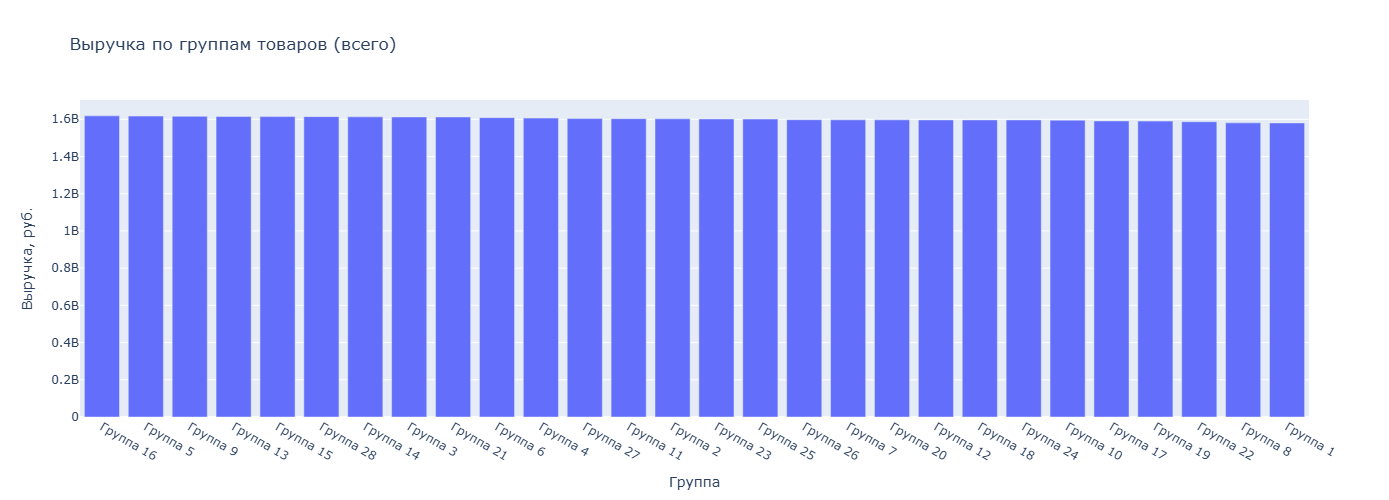

In [63]:
# Топ групп по выручке
top_groups_revenue = df_groups.groupby('Группа')['Выручка'].sum().sort_values(ascending=False)

fig = px.bar(
    x=top_groups_revenue.index,
    y=top_groups_revenue.values,
    title='Выручка по группам товаров (всего)',
    labels={'x': 'Группа', 'y': 'Выручка, руб.'}
)

fig.update_layout(height=500)
fig.show()

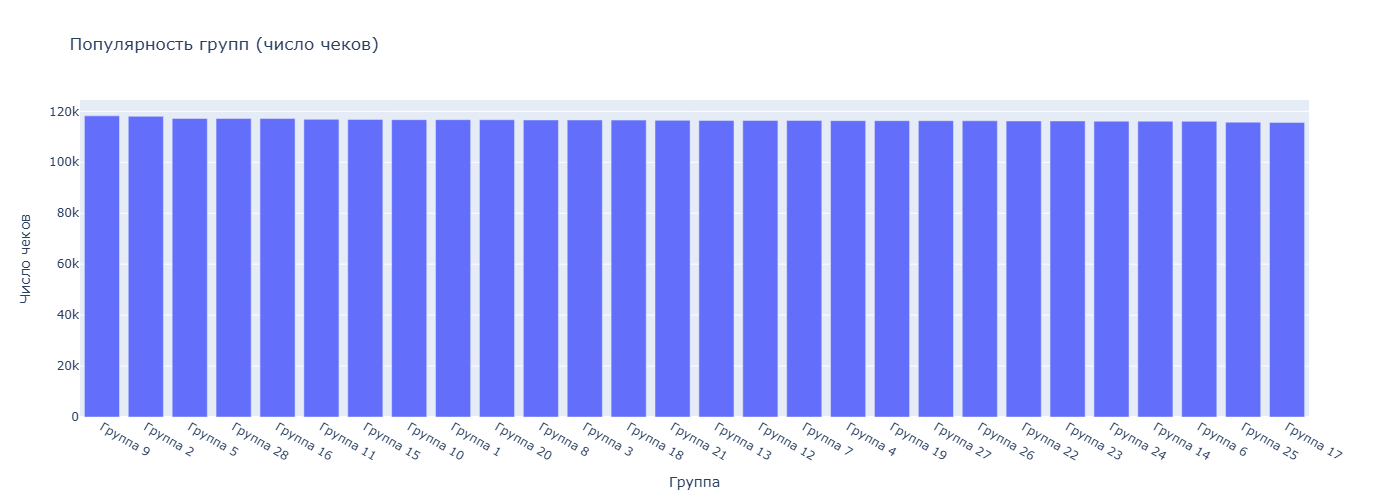

In [64]:
# Топ групп по числу чеков (популярность)
top_groups_checks = df_groups.groupby('Группа')['Чеки'].sum().sort_values(ascending=False)

fig = px.bar(
    x=top_groups_checks.index,
    y=top_groups_checks.values,
    title='Популярность групп (число чеков)',
    labels={'x': 'Группа', 'y': 'Число чеков'}
)

fig.update_layout(height=500)
fig.show()

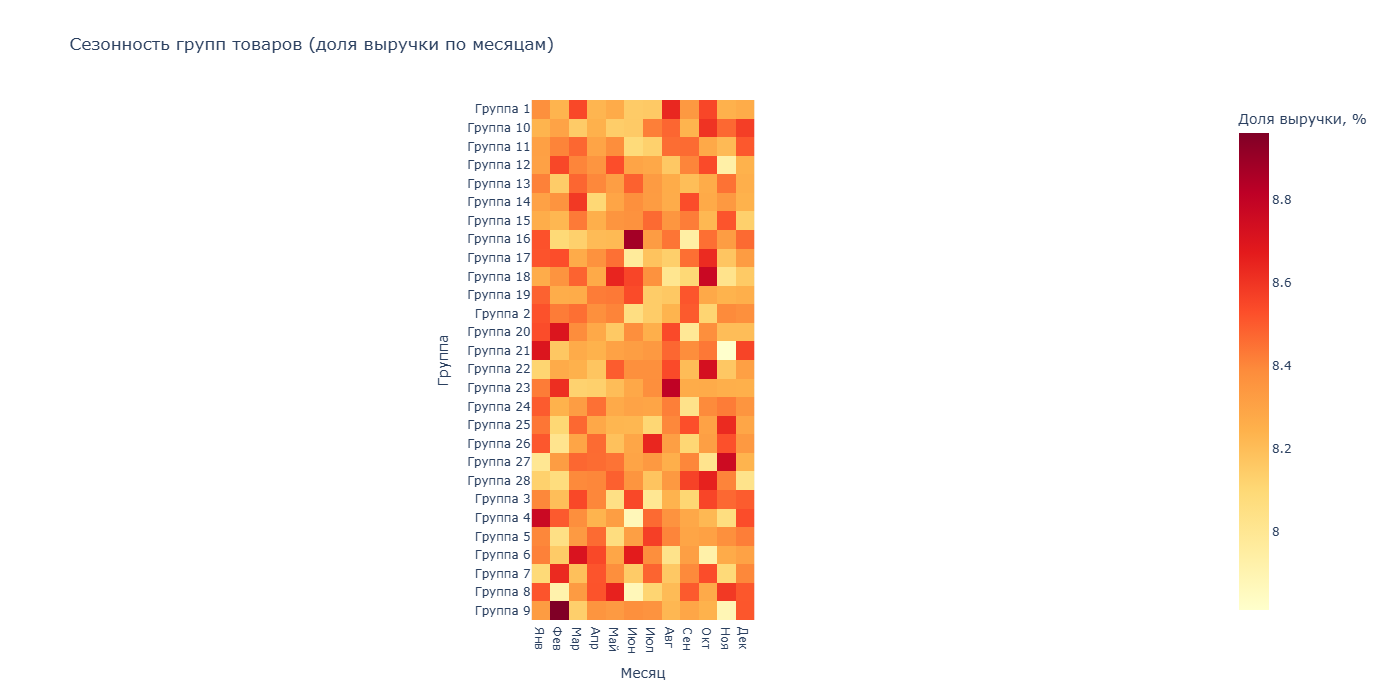

In [65]:
# Сезонность групп (heatmap)
seasonality = df_groups.groupby(['Месяц_номер', 'Группа'])['Выручка'].sum().reset_index()
seasonality_pivot = seasonality.pivot(index='Группа', columns='Месяц_номер', values='Выручка')

# Нормализуем по строкам для видимости паттернов
seasonality_norm = seasonality_pivot.div(seasonality_pivot.sum(axis=1), axis=0) * 100

months_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

fig = px.imshow(
    seasonality_norm,
    labels=dict(x='Месяц', y='Группа', color='Доля выручки, %'),
    x=months_names,
    title='Сезонность групп товаров (доля выручки по месяцам)',
    color_continuous_scale='YlOrRd'
)

fig.update_layout(height=700)
fig.show()

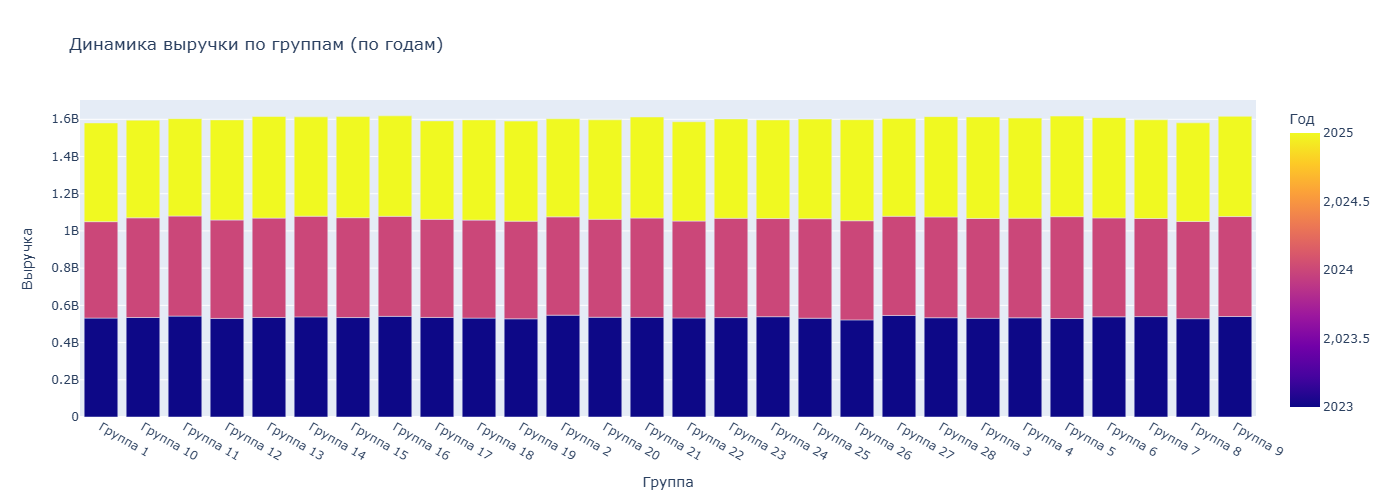

In [66]:
# Динамика групп по годам
groups_by_year = df_groups.groupby(['Год', 'Группа'])['Выручка'].sum().reset_index()

fig = px.bar(
    groups_by_year,
    x='Группа',
    y='Выручка',
    color='Год',
    barmode='group',
    title='Динамика выручки по группам (по годам)'
)

fig.update_layout(height=500)
fig.show()

---
## 6. Связь клиентов и групп

In [67]:
# Добавляем статус клиента к данным по группам
# Берём статусы для 2024 года
statuses_2024 = df_statuses[df_statuses['Год'] == 2024][['ID_клиента', 'Период', 'Статус']]

# Объединяем с основными данными
df_with_status = df.merge(statuses_2024, on=['ID_клиента', 'Период'], how='left')
df_with_status['Статус'] = df_with_status['Статус'].fillna('Неопределён')

# Оставляем только активные статусы
df_active = df_with_status[df_with_status['Статус'].isin(['Новый', 'Постоянный', 'Вернувшийся'])]

print(f'Записей с активным статусом: {len(df_active)}')

Записей с активным статусом: 234600


In [68]:
# Топ групп у новых клиентов
new_clients_data = df_active[df_active['Статус'] == 'Новый']

if len(new_clients_data) > 0:
    new_clients_groups = new_clients_data.groupby('Группа').agg({
        'Чеки': 'sum',
        'Сумма': 'sum',
        'ID_клиента': 'nunique'
    }).sort_values('Чеки', ascending=False)
    new_clients_groups.columns = ['Чеки', 'Выручка', 'Клиентов']
    print('Топ-10 групп у НОВЫХ клиентов:')
    display(new_clients_groups.head(10))
else:
    print('В тестовых данных нет НОВЫХ клиентов (все активны каждый месяц).')
    print('Для демонстрации создадим пустой DataFrame:')
    new_clients_groups = pd.DataFrame(columns=['Чеки', 'Выручка', 'Клиентов'])

В тестовых данных нет НОВЫХ клиентов (все активны каждый месяц).
Для демонстрации создадим пустой DataFrame:


In [69]:
# Топ групп у постоянных клиентов
regular_clients_groups = df_active[df_active['Статус'] == 'Постоянный'].groupby('Группа').agg({
    'Чеки': 'sum',
    'Сумма': 'sum',
    'ID_клиента': 'nunique'
}).sort_values('Чеки', ascending=False)

regular_clients_groups.columns = ['Чеки', 'Выручка', 'Клиентов']

print('Топ-10 групп у ПОСТОЯННЫХ клиентов:')
regular_clients_groups.head(10)

Топ-10 групп у ПОСТОЯННЫХ клиентов:


,Чеки,Выручка,Клиентов
Группа,,,
Группа 2,39347.0,5.284710e+08,1000
Группа 5,39163.0,5.472233e+08,1000
Группа 10,39010.0,5.358025e+08,1000
Группа 28,39008.0,5.414342e+08,1000
Группа 25,38985.0,5.347396e+08,1000
Группа 6,38977.0,5.314618e+08,1000
Группа 9,38973.0,5.372063e+08,1000
Группа 7,38973.0,5.272150e+08,1000
Группа 16,38934.0,5.376555e+08,1000


In [70]:
# Сравнение структуры покупок новых и постоянных
if len(new_clients_groups) > 0 and len(regular_clients_groups) > 0:
    compare_groups = pd.DataFrame({
        'Новые': new_clients_groups['Чеки'],
        'Постоянные': regular_clients_groups['Чеки']
    }).fillna(0)

    # Нормализуем в проценты
    compare_groups['Новые_%'] = compare_groups['Новые'] / compare_groups['Новые'].sum() * 100 if compare_groups['Новые'].sum() > 0 else 0
    compare_groups['Постоянные_%'] = compare_groups['Постоянные'] / compare_groups['Постоянные'].sum() * 100 if compare_groups['Постоянные'].sum() > 0 else 0
    compare_groups['Разница'] = compare_groups['Новые_%'] - compare_groups['Постоянные_%']

    compare_groups_sorted = compare_groups.sort_values('Разница', ascending=False)

    print('Группы, где НОВЫЕ покупают чаще (vs постоянные):')
    print(compare_groups_sorted[['Новые_%', 'Постоянные_%', 'Разница']].head(10).round(2))
else:
    print('Недостаточно данных для сравнения (нет новых клиентов в тестовых данных).')
    print('\\nПоказываем только данные по ПОСТОЯННЫМ клиентам:')
    compare_groups = pd.DataFrame({
        'Постоянные': regular_clients_groups['Чеки']
    }).fillna(0)
    compare_groups['Постоянные_%'] = compare_groups['Постоянные'] / compare_groups['Постоянные'].sum() * 100
    print(compare_groups.sort_values('Постоянные_%', ascending=False).head(10).round(2))

Недостаточно данных для сравнения (нет новых клиентов в тестовых данных).
\nПоказываем только данные по ПОСТОЯННЫМ клиентам:
           Постоянные  Постоянные_%
Группа                             
Группа 2      39347.0          3.62
Группа 5      39163.0          3.60
Группа 10     39010.0          3.59
Группа 28     39008.0          3.59
Группа 25     38985.0          3.59
Группа 6      38977.0          3.59
Группа 9      38973.0          3.59
Группа 7      38973.0          3.59
Группа 16     38934.0          3.58
Группа 23     38915.0          3.58


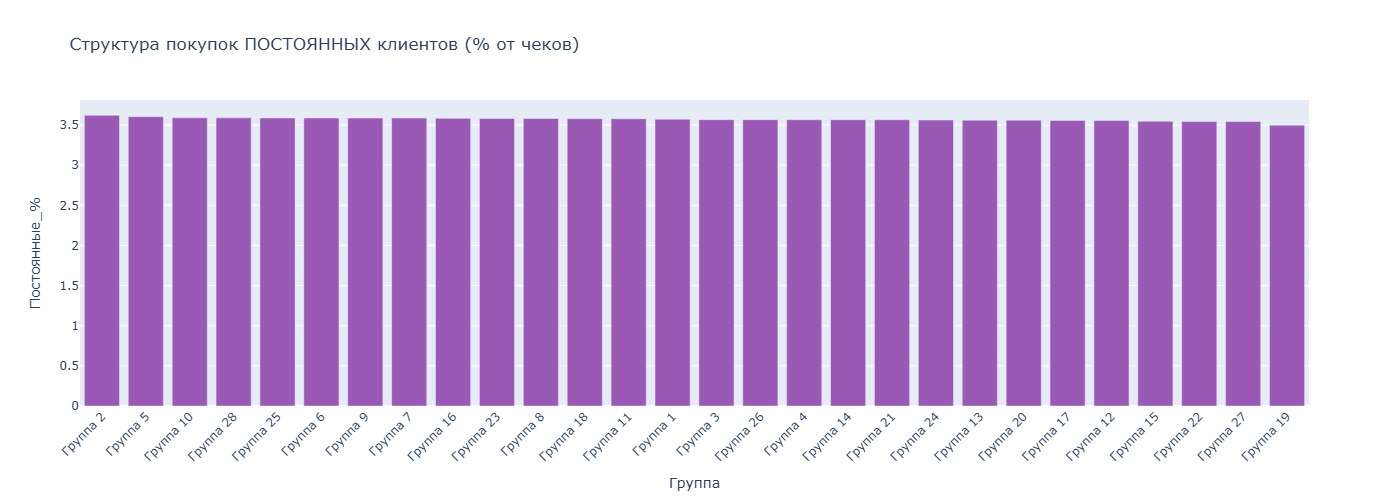

In [71]:
# Визуализация: сравнение новых и постоянных по группам
if 'Новые_%' in compare_groups.columns and 'Постоянные_%' in compare_groups.columns:
    compare_melted = compare_groups[['Новые_%', 'Постоянные_%']].reset_index()
    compare_melted = compare_melted.melt(id_vars='Группа', var_name='Статус', value_name='Доля')
    compare_melted['Статус'] = compare_melted['Статус'].str.replace('_%', '')

    fig = px.bar(
        compare_melted,
        x='Группа',
        y='Доля',
        color='Статус',
        barmode='group',
        title='Структура покупок: Новые vs Постоянные клиенты (% от чеков)',
        color_discrete_map={'Новые': '#2ecc71', 'Постоянные': '#9b59b6'}
    )

    fig.update_layout(height=500, xaxis_tickangle=-45)
    fig.show()
else:
    # Показываем только постоянных
    fig = px.bar(
        compare_groups.reset_index(),
        x='Группа',
        y='Постоянные_%',
        title='Структура покупок ПОСТОЯННЫХ клиентов (% от чеков)',
        color_discrete_sequence=['#9b59b6']
    )
    fig.update_layout(height=500, xaxis_tickangle=-45)
    fig.show()

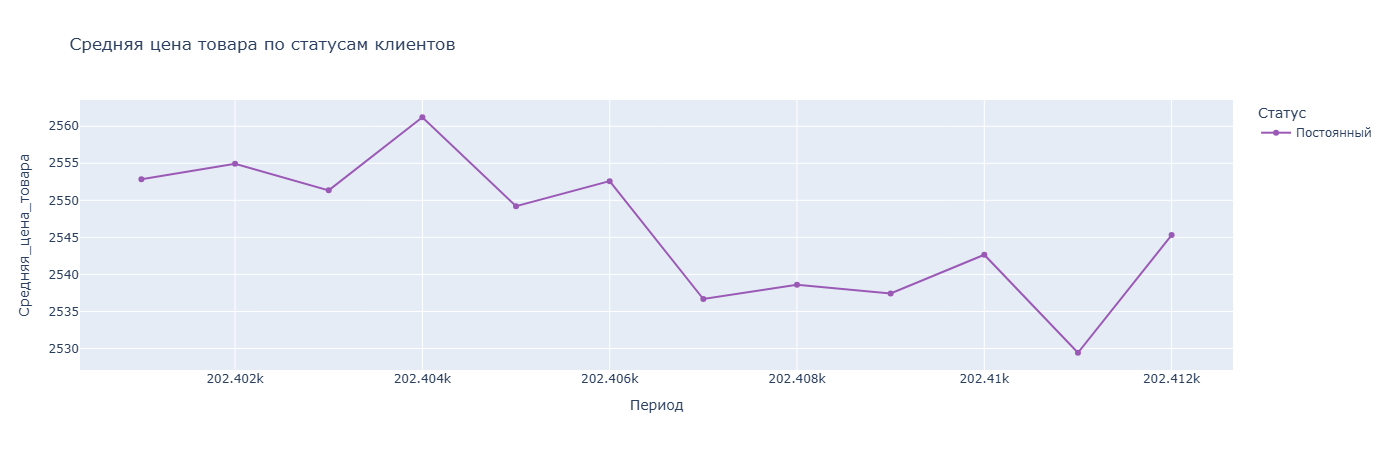

In [72]:
# Средний чек по статусам
avg_check_by_status = df_active.groupby(['Период', 'Статус']).agg({
    'Сумма': 'sum',
    'Количество': 'sum'
}).reset_index()

# Средний чек = сумма / количество (средняя цена товара)
avg_check_by_status['Средняя_цена_товара'] = avg_check_by_status['Сумма'] / avg_check_by_status['Количество']

fig = px.line(
    avg_check_by_status,
    x='Период',
    y='Средняя_цена_товара',
    color='Статус',
    title='Средняя цена товара по статусам клиентов',
    markers=True,
    color_discrete_map={'Новый': '#2ecc71', 'Постоянный': '#9b59b6', 'Вернувшийся': '#3498db'}
)

fig.update_layout(height=450)
fig.show()

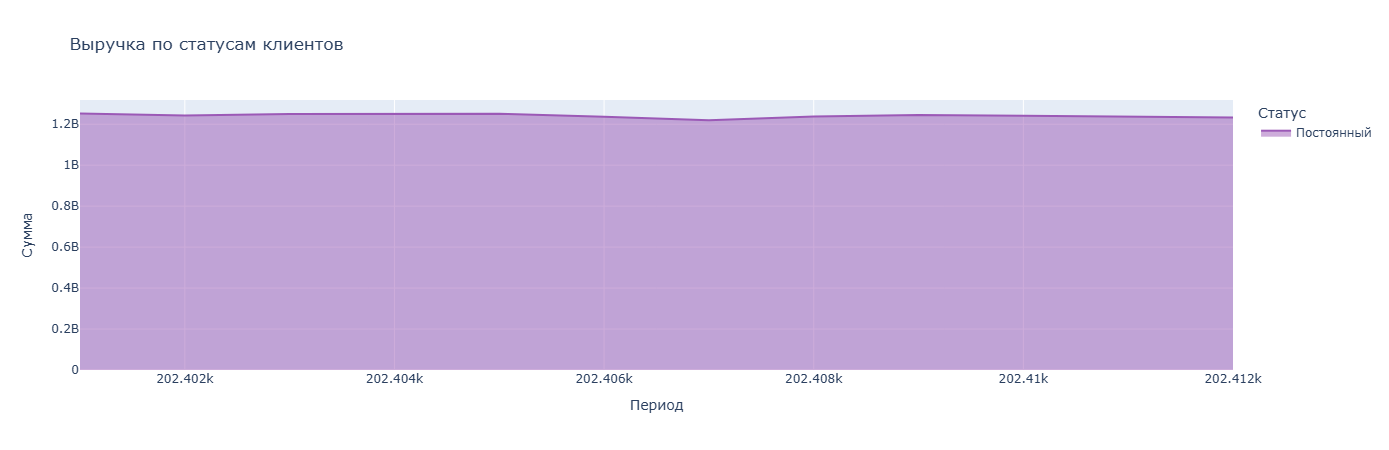

In [73]:
# Общая сумма покупок по статусам
revenue_by_status = df_active.groupby(['Период', 'Статус'])['Сумма'].sum().reset_index()

fig = px.area(
    revenue_by_status,
    x='Период',
    y='Сумма',
    color='Статус',
    title='Выручка по статусам клиентов',
    color_discrete_map={'Новый': '#2ecc71', 'Постоянный': '#9b59b6', 'Вернувшийся': '#3498db'}
)

fig.update_layout(height=450)
fig.show()

---
## 7. Интерактивный дашборд с фильтрами

In [74]:
# Создаём комплексный дашборд с dropdown фильтрами
from plotly.subplots import make_subplots

# Подготовка данных для фильтров
years = sorted(df['Год'].unique())
groups = sorted(df['Группа'].unique())

print(f'Годы для фильтра: {years}')
print(f'Групп для фильтра: {len(groups)}')

Годы для фильтра: [np.int64(2023), np.int64(2024), np.int64(2025)]
Групп для фильтра: 28


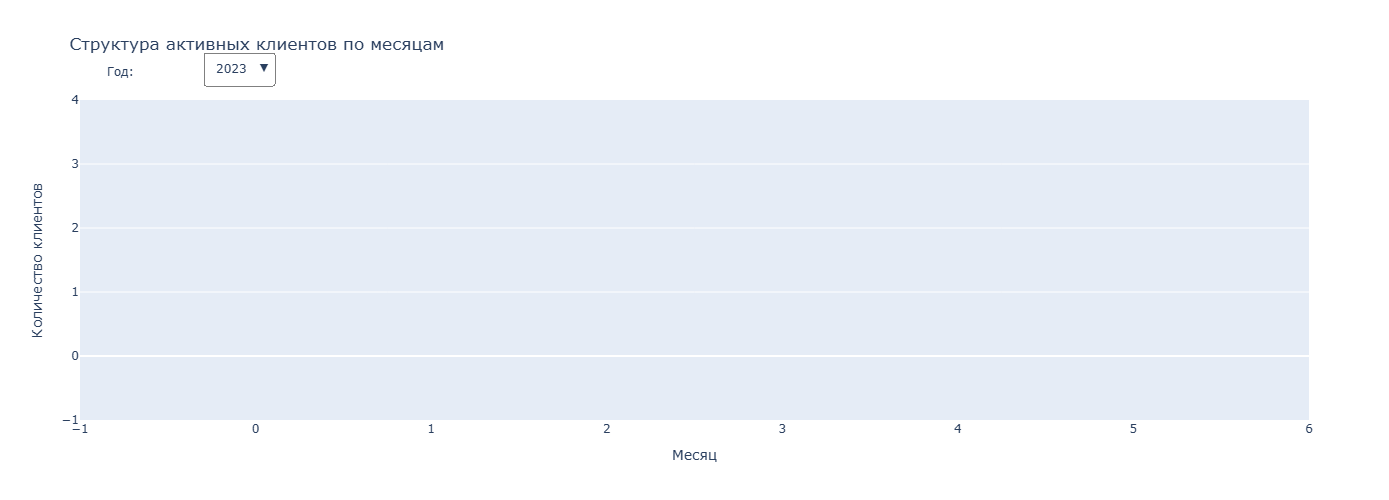

In [75]:
# Дашборд 1: Динамика клиентов с фильтром по году
fig = go.Figure()

# Данные для каждого года
for i, year in enumerate(years):
    year_data = status_dynamics[status_dynamics['Год'] == year]
    
    for status in ['Новый', 'Постоянный', 'Вернувшийся']:
        status_data = year_data[year_data['Статус'] == status]
        
        fig.add_trace(go.Bar(
            x=status_data['Месяц'],
            y=status_data['Количество'],
            name=status,
            marker_color=colors[status],
            visible=(i == 0),  # Первый год видим по умолчанию
            legendgroup=status
        ))

# Создаём кнопки для переключения годов
buttons = []
n_statuses = 3  # Новый, Постоянный, Вернувшийся

for i, year in enumerate(years):
    visibility = [False] * (len(years) * n_statuses)
    for j in range(n_statuses):
        visibility[i * n_statuses + j] = True
    
    buttons.append(dict(
        label=str(year),
        method='update',
        args=[{'visible': visibility}]
    ))

fig.update_layout(
    title='Структура активных клиентов по месяцам',
    barmode='stack',
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.1,
        y=1.15,
        xanchor='left',
        yanchor='top',
        showactive=True,
        bgcolor='white',
        bordercolor='gray'
    )],
    annotations=[dict(
        text='Год:',
        x=0.02,
        y=1.12,
        xref='paper',
        yref='paper',
        showarrow=False
    )],
    height=500,
    xaxis_title='Месяц',
    yaxis_title='Количество клиентов'
)

fig.show()

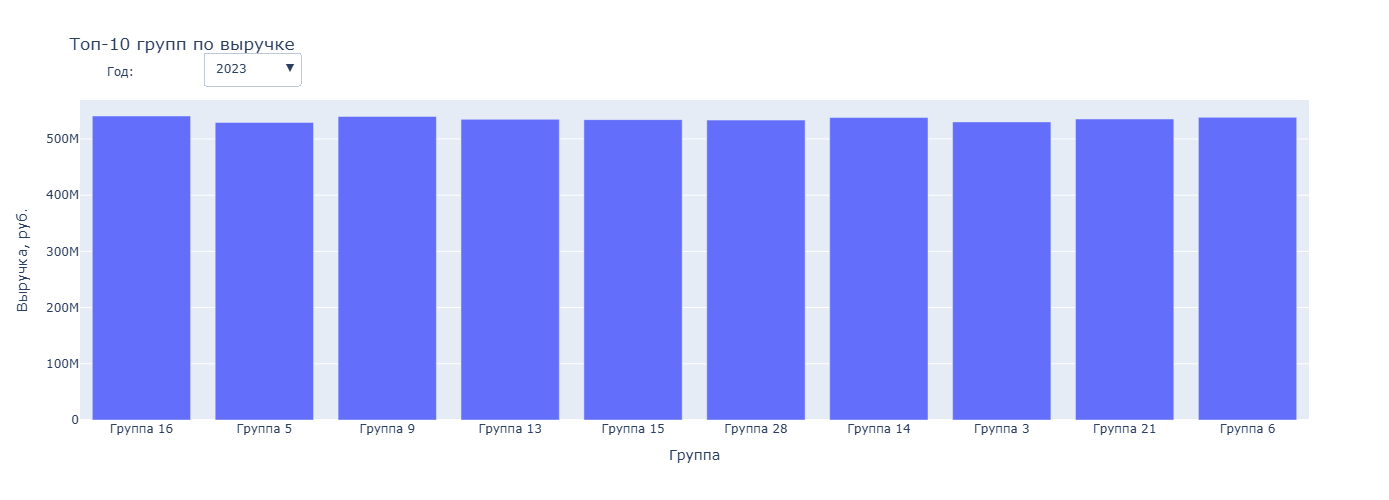

In [76]:
# Дашборд 2: Выручка по группам с фильтром
fig = go.Figure()

# Топ-10 групп для отображения
top_10_groups = top_groups_revenue.head(10).index.tolist()

for i, year in enumerate(years):
    year_data = df_groups[df_groups['Год'] == year]
    year_data = year_data.groupby('Группа')['Выручка'].sum().reindex(top_10_groups)
    
    fig.add_trace(go.Bar(
        x=year_data.index,
        y=year_data.values,
        name=str(year),
        visible=(i == 0)
    ))

buttons = []
for i, year in enumerate(years):
    visibility = [j == i for j in range(len(years))]
    buttons.append(dict(
        label=str(year),
        method='update',
        args=[{'visible': visibility}]
    ))

# Добавляем кнопку "Все годы"
buttons.append(dict(
    label='Все годы',
    method='update',
    args=[{'visible': [True] * len(years)}]
))

fig.update_layout(
    title='Топ-10 групп по выручке',
    barmode='group',
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.1,
        y=1.15,
        xanchor='left',
        yanchor='top'
    )],
    annotations=[dict(
        text='Год:',
        x=0.02,
        y=1.12,
        xref='paper',
        yref='paper',
        showarrow=False
    )],
    height=500,
    xaxis_title='Группа',
    yaxis_title='Выручка, руб.'
)

fig.show()

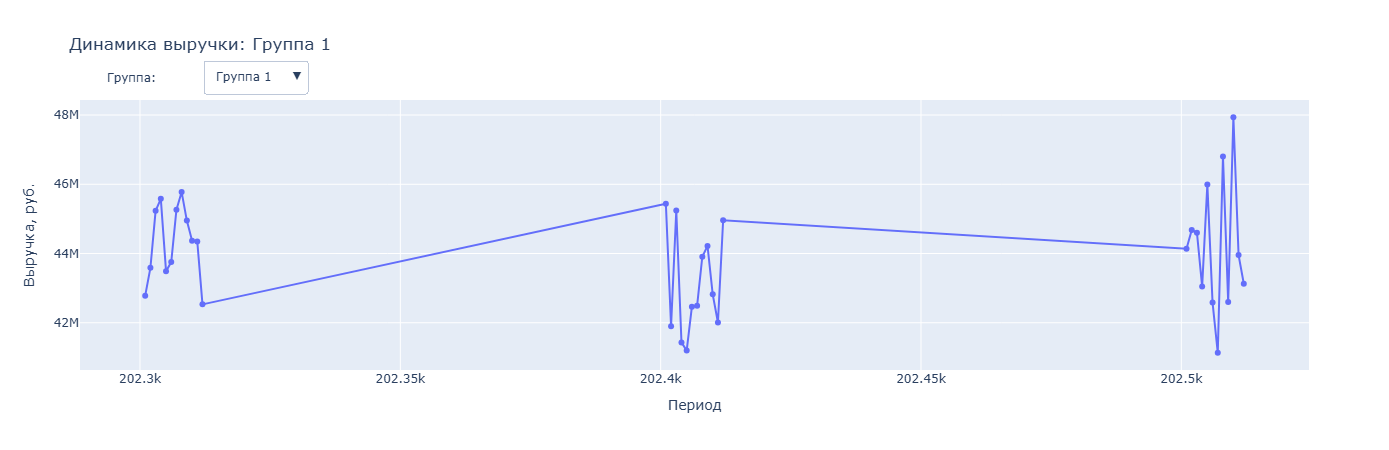

In [77]:
# Дашборд 3: Детализация по выбранной группе
fig = go.Figure()

# Для каждой группы создаём линию динамики
for i, group in enumerate(groups):
    group_data = df_groups[df_groups['Группа'] == group].sort_values('Период')
    
    fig.add_trace(go.Scatter(
        x=group_data['Период'],
        y=group_data['Выручка'],
        mode='lines+markers',
        name=group,
        visible=(i == 0)
    ))

# Dropdown для выбора группы
buttons = []
for i, group in enumerate(groups):
    visibility = [j == i for j in range(len(groups))]
    buttons.append(dict(
        label=group,
        method='update',
        args=[{'visible': visibility},
              {'title': f'Динамика выручки: {group}'}]
    ))

fig.update_layout(
    title=f'Динамика выручки: {groups[0]}',
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.1,
        y=1.15,
        xanchor='left',
        yanchor='top'
    )],
    annotations=[dict(
        text='Группа:',
        x=0.02,
        y=1.12,
        xref='paper',
        yref='paper',
        showarrow=False
    )],
    height=450,
    xaxis_title='Период',
    yaxis_title='Выручка, руб.'
)

fig.show()

---
## 8. Ключевые выводы

In [ ]:
# Автоматические инсайты
print('=' * 60)
print('КЛЮЧЕВЫЕ ВЫВОДЫ')
print('=' * 60)

# 1. Общая статистика
total_clients = df['ID_клиента'].nunique()
total_revenue = df['Сумма'].sum()
print(f'\n1. ОБЩАЯ СТАТИСТИКА')
print(f'   Всего клиентов: {total_clients}')
print(f'   Общая выручка: {total_revenue:,.0f} руб.')

# 2. Динамика клиентов
print(f'\n2. ДИНАМИКА КЛИЕНТОВ')
for year in years:
    active = df_client_month[df_client_month['Год'] == year]['ID_клиента'].nunique()
    print(f'   {year}: {active} активных клиентов')

# 3. Структура по статусам (последний полный год - 2024)
print(f'\n3. СТРУКТУРА КЛИЕНТОВ (2024)')
status_2024 = df_statuses[df_statuses['Год'] == 2024].groupby('Статус').size()
total_2024 = status_2024.sum()
for status in ['Новый', 'Постоянный', 'Вернувшийся', 'Ушедший']:
    if status in status_2024.index:
        count = status_2024[status]
        pct = count / total_2024 * 100
        print(f'   {status}: {count} ({pct:.1f}%)')

# 4. RFM кластеры
print(f'\n4. RFM-КЛАСТЕРЫ (2024)')
rfm_2024 = df_rfm_clustered[df_rfm_clustered['Год'] == 2024]
cluster_dist = rfm_2024['Кластер'].value_counts()
for cluster in cluster_order:
    if cluster in cluster_dist.index:
        print(f'   {cluster}: {cluster_dist[cluster]} клиентов')

# 5. Топ группы
print(f'\n5. ТОП-5 ГРУПП ПО ВЫРУЧКЕ')
for i, (group, revenue) in enumerate(top_groups_revenue.head(5).items(), 1):
    print(f'   {i}. {group}: {revenue:,.0f} руб.')

# 6. Различия новых и постоянных
print(f'\n6. СРАВНЕНИЕ НОВЫХ И ПОСТОЯННЫХ')
new_data = df_active[df_active['Статус'] == 'Новый']
regular_data = df_active[df_active['Статус'] == 'Постоянный']

if len(new_data) > 0 and len(regular_data) > 0:
    new_avg = new_data['Сумма'].mean()
    regular_avg = regular_data['Сумма'].mean()
    diff_pct = (new_avg / regular_avg - 1) * 100
    print(f'   Средняя сумма покупки:')
    print(f'   - Новые: {new_avg:,.0f} руб.')
    print(f'   - Постоянные: {regular_avg:,.0f} руб.')
    print(f'   - Разница: {diff_pct:+.1f}%')
else:
    print('   В тестовых данных все клиенты постоянные.')
    if len(regular_data) > 0:
        regular_avg = regular_data['Сумма'].mean()
        print(f'   Средняя сумма покупки постоянных: {regular_avg:,.0f} руб.')

print('\n' + '=' * 60)

In [ ]:
# Экспорт в HTML
from plotly.io import write_html

# Создаём итоговый HTML с несколькими графиками
html_content = '''
<!DOCTYPE html>
<html>
<head>
    <title>Аналитика клиентов и групп товаров</title>
    <meta charset="utf-8">
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; background: #f5f5f5; }
        h1 { color: #2c3e50; text-align: center; }
        h2 { color: #34495e; border-bottom: 2px solid #3498db; padding-bottom: 10px; }
        .chart-container { background: white; padding: 20px; margin: 20px 0; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
        .kpi-container { display: flex; justify-content: space-around; flex-wrap: wrap; margin: 20px 0; }
        .kpi-card { background: white; padding: 20px 40px; border-radius: 10px; text-align: center; box-shadow: 0 2px 5px rgba(0,0,0,0.1); margin: 10px; }
        .kpi-value { font-size: 2.5em; font-weight: bold; color: #2c3e50; }
        .kpi-label { font-size: 1em; color: #7f8c8d; margin-top: 5px; }
    </style>
</head>
<body>
    <h1>Аналитика клиентов и групп товаров (2023-2025)</h1>
    
    <div class="kpi-container">
        <div class="kpi-card">
            <div class="kpi-value">''' + str(total_clients) + '''</div>
            <div class="kpi-label">Всего клиентов</div>
        </div>
        <div class="kpi-card">
            <div class="kpi-value">''' + f'{total_revenue/1e6:.1f}M' + '''</div>
            <div class="kpi-label">Выручка, руб.</div>
        </div>
        <div class="kpi-card">
            <div class="kpi-value">28</div>
            <div class="kpi-label">Групп товаров</div>
        </div>
        <div class="kpi-card">
            <div class="kpi-value">36</div>
            <div class="kpi-label">Месяцев данных</div>
        </div>
    </div>
'''

print('HTML шаблон создан. Для полного экспорта запустите следующую ячейку.')

In [ ]:
# Сохранение отдельных графиков
# График 1: Динамика статусов
fig1 = px.bar(
    status_active,
    x='Период',
    y='Количество',
    color='Статус',
    title='Структура активных клиентов по месяцам',
    category_orders={'Статус': [s for s in active_statuses if s in status_active['Статус'].unique()]},
    color_discrete_map=colors,
    barmode='stack'
)
fig1.write_html('chart_client_dynamics.html', include_plotlyjs='cdn')

# График 2: RFM кластеры
fig2 = px.bar(
    cluster_counts,
    x='Год',
    y='Количество',
    color='Кластер',
    title='Распределение по RFM-кластерам',
    category_orders={'Кластер': cluster_order},
    color_discrete_map=cluster_colors,
    barmode='group',
    text='Количество'
)
fig2.write_html('chart_rfm_clusters.html', include_plotlyjs='cdn')

# График 3: Sankey миграция
fig3 = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color='black', width=0.5), label=all_labels, color=node_colors),
    link=dict(source=sources, target=targets, value=values)
)])
fig3.update_layout(title='Миграция клиентов между кластерами', height=700)
fig3.write_html('chart_migration_sankey.html', include_plotlyjs='cdn')

# График 4: Сезонность групп
fig4 = px.imshow(
    seasonality_norm,
    labels=dict(x='Месяц', y='Группа', color='Доля, %'),
    x=months_names,
    title='Сезонность групп товаров',
    color_continuous_scale='YlOrRd'
)
fig4.update_layout(height=700)
fig4.write_html('chart_seasonality.html', include_plotlyjs='cdn')

# График 5: Сравнение новых и постоянных (или только постоянные)
if 'Новые_%' in compare_groups.columns and 'Постоянные_%' in compare_groups.columns:
    compare_melted = compare_groups[['Новые_%', 'Постоянные_%']].reset_index()
    compare_melted = compare_melted.melt(id_vars='Группа', var_name='Статус', value_name='Доля')
    compare_melted['Статус'] = compare_melted['Статус'].str.replace('_%', '')
    
    fig5 = px.bar(
        compare_melted,
        x='Группа',
        y='Доля',
        color='Статус',
        barmode='group',
        title='Структура покупок: Новые vs Постоянные',
        color_discrete_map={'Новые': '#2ecc71', 'Постоянные': '#9b59b6'}
    )
else:
    fig5 = px.bar(
        compare_groups.reset_index(),
        x='Группа',
        y='Постоянные_%',
        title='Структура покупок ПОСТОЯННЫХ клиентов',
        color_discrete_sequence=['#9b59b6']
    )
    
fig5.update_layout(height=500, xaxis_tickangle=-45)
fig5.write_html('chart_new_vs_regular.html', include_plotlyjs='cdn')

print('Графики сохранены:')
print('- chart_client_dynamics.html')
print('- chart_rfm_clusters.html')
print('- chart_migration_sankey.html')
print('- chart_seasonality.html')
print('- chart_new_vs_regular.html')

In [ ]:
# ЭКСПОРТ В ЕДИНЫЙ HTML ФАЙЛ
import plotly.io as pio

# Собираем все графики
all_figures = []

# 1. Динамика статусов
fig_status = px.bar(
    status_active, x='Период', y='Количество', color='Статус',
    title='1. Структура активных клиентов по месяцам',
    category_orders={'Статус': [s for s in active_statuses if s in status_active['Статус'].unique()]},
    color_discrete_map=colors, barmode='stack'
)
fig_status.update_layout(height=450)
all_figures.append(('Динамика статусов', fig_status))

# 2. RFM кластеры
fig_rfm = px.bar(
    cluster_counts, x='Год', y='Количество', color='Кластер',
    title='2. Распределение по RFM-кластерам',
    category_orders={'Кластер': cluster_order},
    color_discrete_map=cluster_colors, barmode='group', text='Количество'
)
fig_rfm.update_layout(height=450)
all_figures.append(('RFM-кластеры', fig_rfm))

# 3. Radar профили
fig_radar = go.Figure()
for cluster in cluster_order:
    if cluster in cluster_profile_norm.index:
        values = cluster_profile_norm.loc[cluster].tolist()
        values.append(values[0])
        fig_radar.add_trace(go.Scatterpolar(
            r=values, theta=['Recency', 'Frequency', 'Monetary', 'Recency'],
            fill='toself', name=cluster, line_color=cluster_colors[cluster]
        ))
fig_radar.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
                        title='3. Профили RFM-кластеров', height=450)
all_figures.append(('Профили кластеров', fig_radar))

# 4. Sankey миграция
fig_sankey = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color='black', width=0.5), label=all_labels, color=node_colors),
    link=dict(source=sources, target=targets, value=values)
)])
fig_sankey.update_layout(title='4. Миграция клиентов между кластерами (2023→2024→2025)', height=600)
all_figures.append(('Миграция клиентов', fig_sankey))

# 5. Топ групп по выручке
fig_top = px.bar(x=top_groups_revenue.index, y=top_groups_revenue.values,
                 title='5. Выручка по группам товаров', labels={'x': 'Группа', 'y': 'Выручка, руб.'})
fig_top.update_layout(height=400)
all_figures.append(('Топ групп', fig_top))

# 6. Сезонность
fig_season = px.imshow(seasonality_norm, labels=dict(x='Месяц', y='Группа', color='Доля, %'),
                       x=months_names, title='6. Сезонность групп товаров', color_continuous_scale='YlOrRd')
fig_season.update_layout(height=600)
all_figures.append(('Сезонность', fig_season))

# 7. Динамика по годам
fig_years = px.bar(groups_by_year, x='Группа', y='Выручка', color='Год', barmode='group',
                   title='7. Динамика выручки по группам (по годам)')
fig_years.update_layout(height=450)
all_figures.append(('Динамика по годам', fig_years))

# 8. Структура покупок по статусам
if 'Новые_%' in compare_groups.columns:
    compare_melted = compare_groups[['Новые_%', 'Постоянные_%']].reset_index()
    compare_melted = compare_melted.melt(id_vars='Группа', var_name='Статус', value_name='Доля')
    compare_melted['Статус'] = compare_melted['Статус'].str.replace('_%', '')
    fig_compare = px.bar(compare_melted, x='Группа', y='Доля', color='Статус', barmode='group',
                         title='8. Структура покупок: Новые vs Постоянные',
                         color_discrete_map={'Новые': '#2ecc71', 'Постоянные': '#9b59b6'})
else:
    fig_compare = px.bar(compare_groups.reset_index(), x='Группа', y='Постоянные_%',
                         title='8. Структура покупок постоянных клиентов', color_discrete_sequence=['#9b59b6'])
fig_compare.update_layout(height=400, xaxis_tickangle=-45)
all_figures.append(('Структура покупок', fig_compare))

print(f'Подготовлено {len(all_figures)} графиков для экспорта')

In [ ]:
# ГЕНЕРАЦИЯ ЕДИНОГО HTML ФАЙЛА
from datetime import datetime

# HTML шаблон
html_output = f'''<!DOCTYPE html>
<html lang="ru">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Аналитика клиентов и групп товаров</title>
    <script src="https://cdn.plot.ly/plotly-2.27.0.min.js"></script>
    <style>
        * {{ box-sizing: border-box; }}
        body {{ 
            font-family: 'Segoe UI', Arial, sans-serif; 
            margin: 0; padding: 20px; 
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            min-height: 100vh;
        }}
        .container {{ max-width: 1400px; margin: 0 auto; }}
        h1 {{ 
            color: white; text-align: center; 
            font-size: 2.5em; margin-bottom: 10px;
            text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
        }}
        .subtitle {{ 
            color: rgba(255,255,255,0.9); text-align: center; 
            margin-bottom: 30px; font-size: 1.1em;
        }}
        .kpi-container {{ 
            display: grid; 
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 20px; margin-bottom: 30px; 
        }}
        .kpi-card {{ 
            background: white; padding: 25px; 
            border-radius: 15px; text-align: center; 
            box-shadow: 0 10px 30px rgba(0,0,0,0.2);
            transition: transform 0.3s;
        }}
        .kpi-card:hover {{ transform: translateY(-5px); }}
        .kpi-value {{ 
            font-size: 2.8em; font-weight: bold; 
            background: linear-gradient(135deg, #667eea, #764ba2);
            -webkit-background-clip: text; -webkit-text-fill-color: transparent;
        }}
        .kpi-label {{ font-size: 1em; color: #666; margin-top: 8px; }}
        .chart-section {{ 
            background: white; padding: 25px; 
            margin-bottom: 25px; border-radius: 15px; 
            box-shadow: 0 10px 30px rgba(0,0,0,0.15);
        }}
        .section-title {{
            font-size: 1.3em; color: #333; 
            margin-bottom: 15px; padding-bottom: 10px;
            border-bottom: 3px solid #667eea;
        }}
        .insights {{
            background: white; padding: 30px;
            border-radius: 15px; margin-bottom: 25px;
            box-shadow: 0 10px 30px rgba(0,0,0,0.15);
        }}
        .insights h2 {{ color: #333; margin-top: 0; }}
        .insights ul {{ line-height: 1.8; }}
        .insights li {{ margin-bottom: 8px; }}
        .footer {{
            text-align: center; color: rgba(255,255,255,0.8);
            margin-top: 30px; padding: 20px;
        }}
        .nav {{
            background: rgba(255,255,255,0.95); padding: 15px;
            border-radius: 10px; margin-bottom: 25px;
            display: flex; flex-wrap: wrap; gap: 10px;
            justify-content: center;
        }}
        .nav a {{
            padding: 8px 16px; background: #667eea;
            color: white; text-decoration: none;
            border-radius: 20px; font-size: 0.9em;
            transition: background 0.3s;
        }}
        .nav a:hover {{ background: #764ba2; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>📊 Аналитика клиентов и групп товаров</h1>
        <p class="subtitle">Период: 2023-2025 | Сгенерировано: {datetime.now().strftime("%d.%m.%Y %H:%M")}</p>
        
        <div class="kpi-container">
            <div class="kpi-card">
                <div class="kpi-value">{total_clients:,}</div>
                <div class="kpi-label">Всего клиентов</div>
            </div>
            <div class="kpi-card">
                <div class="kpi-value">{total_revenue/1e9:.2f}B</div>
                <div class="kpi-label">Выручка, руб.</div>
            </div>
            <div class="kpi-card">
                <div class="kpi-value">28</div>
                <div class="kpi-label">Групп товаров</div>
            </div>
            <div class="kpi-card">
                <div class="kpi-value">36</div>
                <div class="kpi-label">Месяцев данных</div>
            </div>
        </div>
        
        <nav class="nav">
            <a href="#status">Статусы клиентов</a>
            <a href="#rfm">RFM-анализ</a>
            <a href="#migration">Миграция</a>
            <a href="#groups">Группы товаров</a>
            <a href="#insights">Выводы</a>
        </nav>
'''

# Добавляем графики
for i, (title, fig) in enumerate(all_figures):
    chart_id = f'chart_{i}'
    section_id = ['status', 'rfm', 'rfm', 'migration', 'groups', 'groups', 'groups', 'compare'][i] if i < 8 else f'section_{i}'
    
    html_output += f'''
        <div class="chart-section" id="{section_id}">
            <div id="{chart_id}"></div>
        </div>
    '''

# Добавляем выводы
html_output += f'''
        <div class="insights" id="insights">
            <h2>📈 Ключевые выводы</h2>
            <ul>
                <li><strong>Всего клиентов:</strong> {total_clients} за период 2023-2025</li>
                <li><strong>Общая выручка:</strong> {total_revenue:,.0f} руб.</li>
                <li><strong>RFM-кластеры 2024:</strong> {', '.join([f'{c}: {cluster_dist.get(c, 0)}' for c in cluster_order[:3]])}</li>
                <li><strong>Топ-3 группы по выручке:</strong> {', '.join(top_groups_revenue.head(3).index.tolist())}</li>
            </ul>
        </div>
        
        <div class="footer">
            <p>Отчёт создан автоматически | Python + Plotly</p>
        </div>
    </div>
    
    <script>
'''

# Добавляем JS для каждого графика
for i, (title, fig) in enumerate(all_figures):
    chart_id = f'chart_{i}'
    fig_json = pio.to_json(fig)
    html_output += f'''
        Plotly.newPlot("{chart_id}", {fig_json});
    '''

html_output += '''
    </script>
</body>
</html>
'''

# Сохраняем файл
output_file = 'customer_analytics_report.html'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(html_output)

print(f'✅ Единый HTML отчёт сохранён: {output_file}')
print(f'   Размер файла: {len(html_output) / 1024:.1f} KB')
print(f'   Графиков: {len(all_figures)}')